⚠️ Barbell not reliably detected, defaulting to pose landmarks


I0000 00:00:1743818060.266577  572725 gl_context.cc:369] GL version: 2.1 (2.1 ATI-6.1.13), renderer: AMD Radeon Pro 555X OpenGL Engine
W0000 00:00:1743818060.479554 1400688 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743818060.549883 1400690 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


✅ Best tracking landmark selected: head


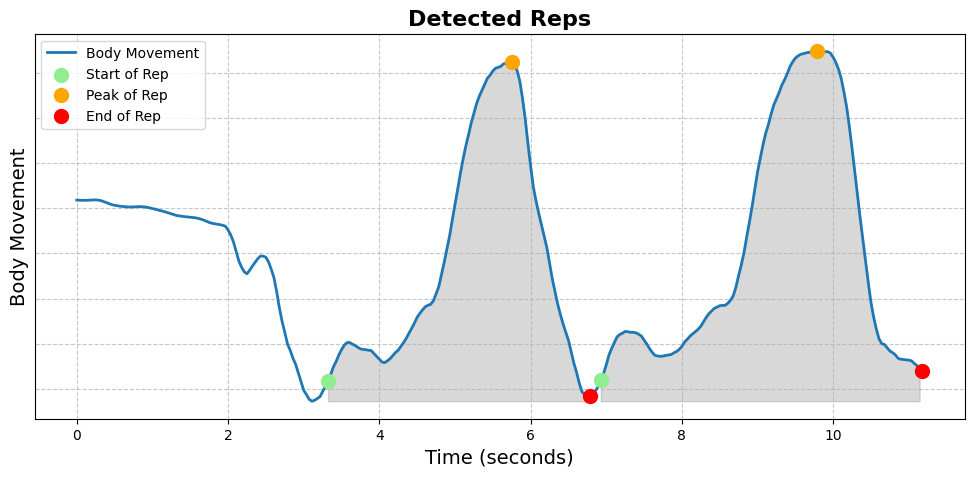

✅ Final video saved with updated rep detection and RPE calculations
outputs/Jamie_Deadlift_rep_annotated_output.mp4
📊 Data exported:
outputs/Jamie_Deadlift_rep_data.csv
outputs/Jamie_Deadlift_rep_data.json


In [3]:
import cv2
import numpy as np
from PIL import ImageFont, ImageDraw, Image
import os
import pandas as pd
import json
import mediapipe as mp
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Set video path directly for Jupyter use
video_path = "/Users/stephaniesanzo/gym-log-mvp/inputs/Jamie_Deadlift.mov"

# Check if video exists
if not os.path.exists(video_path):
    raise FileNotFoundError(f"Video file not found: {video_path}")

# Reload video
cap = cv2.VideoCapture(video_path)
fps = int(cap.get(cv2.CAP_PROP_FPS))

# Read first frame to check orientation
ret, test_frame = cap.read()
if not ret:
    raise ValueError("Couldn't read video")

frame_height, frame_width = test_frame.shape[:2]
rotate_video = frame_width > frame_height

if rotate_video:
    out_width, out_height = frame_height, frame_width
else:
    out_width, out_height = frame_width, frame_height

cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

# Output paths
output_base = os.path.splitext(os.path.basename(video_path))[0]
rep_video_path = f"outputs/{output_base}_rep_annotated_output.mp4"
csv_path = f"outputs/{output_base}_rep_data.csv"
json_path = f"outputs/{output_base}_rep_data.json"

# Run YOLOv8 object detection on the first 50 frames
yolo_model = YOLO("yolov8n.pt")
barbell_positions = []
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

for _ in range(50):
    ret, frame = cap.read()
    if not ret:
        break
    results = yolo_model(frame, verbose=False)
    for result in results:
        if hasattr(result, 'names') and hasattr(result, 'boxes'):
            for i, box in enumerate(result.boxes):
                label = result.names[int(box.cls[0])]
                if label.lower() == "barbell":
                    xyxy = box.xyxy[0].cpu().numpy()
                    x_center = (xyxy[0] + xyxy[2]) / 2
                    y_center = (xyxy[1] + xyxy[3]) / 2
                    barbell_positions.append(y_center)

# If barbell found in most frames, use it
if len(barbell_positions) >= 20:
    print("✅ Using YOLOv8-detected barbell for tracking")
    raw_y = np.array(barbell_positions)
    landmark_source = "barbell"
else:
    print("⚠️ Barbell not reliably detected, defaulting to pose landmarks")

    # Initialize Mediapipe Pose
    mp_pose = mp.solutions.pose
    landmark_dict = {
        "left_wrist": mp_pose.PoseLandmark.LEFT_WRIST,
        "right_wrist": mp_pose.PoseLandmark.RIGHT_WRIST,
        "left_ankle": mp_pose.PoseLandmark.LEFT_ANKLE,
        "right_ankle": mp_pose.PoseLandmark.RIGHT_ANKLE,
        "hip": mp_pose.PoseLandmark.LEFT_HIP,
        "head": mp_pose.PoseLandmark.NOSE
    }

    landmark_positions = {k: [] for k in landmark_dict.keys()}
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

    with mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = pose.process(image)
            if results.pose_landmarks:
                for name, lm in landmark_dict.items():
                    y_pos = results.pose_landmarks.landmark[lm].y
                    landmark_positions[name].append(y_pos)

    cap.release()
    # Select the landmark with the highest total movement
    total_displacements = {k: np.sum(np.abs(np.diff(v))) for k, v in landmark_positions.items() if len(v) > 1}
    best_landmark = max(total_displacements, key=total_displacements.get)
    print(f"✅ Best tracking landmark selected: {best_landmark}")
    raw_y = np.array(landmark_positions[best_landmark])
    landmark_source = best_landmark

# Smooth and time conversion
smooth_y = np.convolve(raw_y, np.ones(5)/5, mode='valid')
time_axis = np.arange(len(smooth_y)) / fps

# Detect reps
rep_frames = []
state = "down"
threshold = 0.003

for i in range(1, len(smooth_y)):
    if state == "down" and smooth_y[i] > smooth_y[i - 1] + threshold:
        state = "up"
        rep_frames.append({"start": i})
    elif state == "up" and smooth_y[i] < smooth_y[i - 1] - threshold:
        state = "down"
        if rep_frames and "peak" not in rep_frames[-1]:
            rep_frames[-1]["end"] = i

# Adjust peak and stop
for rep in rep_frames:
    if "start" in rep and "end" in rep:
        start = rep["start"]
        end = rep["end"]
        peak_idx = np.argmax(smooth_y[start:end]) + start
        rep["peak"] = peak_idx
        if peak_idx < len(smooth_y) - 1:
            min_idx = np.argmin(smooth_y[peak_idx:]) + peak_idx
            rep["stop"] = min_idx

# Plot
plt.figure(figsize=(12, 5))
plt.plot(time_axis, smooth_y, label="Body Movement", linewidth=2)

for rep in rep_frames:
    if all(k in rep for k in ["start", "peak", "stop"]):
        plt.scatter(time_axis[rep["start"]], smooth_y[rep["start"]], color='lightgreen', s=100, label="Start of Rep", zorder=5)
        plt.scatter(time_axis[rep["peak"]], smooth_y[rep["peak"]], color='orange', s=100, label="Peak of Rep", zorder=5)
        plt.scatter(time_axis[rep["stop"]], smooth_y[rep["stop"]], color='red', s=100, label="End of Rep", zorder=5)
        plt.fill_between(time_axis[rep["start"]:rep["stop"]], smooth_y[rep["start"]:rep["stop"]], min(smooth_y), color='gray', alpha=0.3)

# Unique legend
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
plt.legend(unique_labels.values(), unique_labels.keys())

plt.xlabel("Time (seconds)", fontsize=14)
plt.ylabel("Body Movement", fontsize=14)
plt.title("Detected Reps", fontsize=16, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tick_params(axis='y', left=False, labelleft=False)
plt.show()

print("✅ Final video saved with updated rep detection and RPE calculations")
print(rep_video_path)
print("📊 Data exported:")
print(csv_path)
print(json_path)

In [39]:
import cv2
import numpy as np
from PIL import ImageFont, ImageDraw, Image
import os
import pandas as pd
import json
import mediapipe as mp
import matplotlib.pyplot as plt

def get_rep_data(json_path):
    """Loads rep data from JSON file for use in the app."""
    if os.path.exists(json_path):
        with open(json_path, "r") as f:
            rep_data = json.load(f)
        return rep_data
    return []

# Set video path
video_path = "/Users/stephaniesanzo/gym-log-mvp/inputs/Jamie_Deadlift.mov"

# Reload video
cap = cv2.VideoCapture(video_path)
fps = int(cap.get(cv2.CAP_PROP_FPS))
print(f"Detected FPS: {fps}")  # Debugging FPS value

# Read first frame to check orientation
ret, test_frame = cap.read()
if not ret:
    raise ValueError("Couldn't read video")

frame_height, frame_width = test_frame.shape[:2]
rotate_video = frame_width > frame_height

if rotate_video:
    out_width, out_height = frame_height, frame_width
else:
    out_width, out_height = frame_width, frame_height

cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

rep_video_path = "/Users/stephaniesanzo/gym-log-mvp/outputs/rep_annotated_output.mp4"
csv_path = "/Users/stephaniesanzo/gym-log-mvp/outputs/rep_data.csv"
json_path = "/Users/stephaniesanzo/gym-log-mvp/outputs/rep_data.json"

# Load fonts
font_path_black = "/Library/Fonts/SF-Pro-Display-Black.otf"
font_path_bold = "/Library/Fonts/SF-Pro-Display-Bold.otf"
font_path_medium = "/Library/Fonts/SF-Pro-Display-Medium.otf"
try:
    font_rep_count = ImageFont.truetype(font_path_black, 350)  # Rep Count
    font_rpe = ImageFont.truetype(font_path_bold, 125)  # RPE
    font_rir = ImageFont.truetype(font_path_medium, 95)  # RIR
except IOError:
    font_rep_count = ImageFont.load_default()
    font_rpe = ImageFont.load_default()
    font_rir = ImageFont.load_default()

# Load and adjust rep data
rep_data = get_rep_data(json_path)
for rep in rep_data:
    start_idx = rep["time_sec"] * fps
    stop_idx = start_idx + (rep["duration_sec"] * fps)
    actual_duration = (stop_idx - start_idx) / fps
    print(f"Rep {rep['rep']} - Frames: {stop_idx - start_idx}, Duration: {actual_duration:.2f}s")
    
    # Compute TUT: Concentric + Eccentric
    concentric_duration = rep["duration_sec"]
    eccentric_duration = concentric_duration * 1.2  # Approximate eccentric phase
    total_TUT = concentric_duration + eccentric_duration
    rep["total_TUT"] = round(total_TUT, 2)
    
    # Corrected RPE scale (Longer duration = Higher RPE)
    duration = rep["duration_sec"]
    if duration >= 3.50:
        rep["estimated_RPE"] = 10.0
    elif duration >= 3.00:
        rep["estimated_RPE"] = 9.5
    elif duration >= 2.50:
        rep["estimated_RPE"] = 9.0
    elif duration >= 2.00:
        rep["estimated_RPE"] = 8.5
    elif duration >= 1.50:
        rep["estimated_RPE"] = 8.0
    elif duration >= 1.00:
        rep["estimated_RPE"] = 7.5
    else:
        rep["estimated_RPE"] = 7.0

    # Convert RPE to RIR
    rpe_to_rir = {
        10.0: "(Possibly 0 Reps in the Tank)",
        9.5: "(Possibly 0-1 Reps in the Tank)",
        9.0: "(Possibly 1-2 Reps in the Tank)",
        8.5: "(Possibly 2-3 Reps in the Tank)",
        8.0: "(Possibly 3-4 Reps in the Tank)",
        7.5: "(Possibly 4+ Reps in the Tank)",
        7.0: "(Possibly 5+ Reps in the Tank)"
    }
    rep["estimated_RIR"] = rpe_to_rir.get(rep["estimated_RPE"], "Unknown")

# Save updated rep data
with open(json_path, "w") as f:
    json.dump(rep_data, f, indent=4)

# Annotate video
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
out = cv2.VideoWriter(rep_video_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (out_width, out_height))

frame_idx = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    if rotate_video:
        frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)

    frame = np.array(frame)
    out.write(frame)
    frame_idx += 1

cap.release()

# Add Summary Screen
summary_frame = np.zeros((out_height, out_width, 3), dtype=np.uint8)
pil_summary = Image.fromarray(summary_frame).convert("RGB")
draw_summary = ImageDraw.Draw(pil_summary)

# Calculate final rep’s RPE and RIR estimate
if rep_data:
    final_rep = rep_data[-1]
    final_rep_rpe = final_rep["estimated_RPE"]
    final_rep_rir = final_rep["estimated_RIR"]
    final_tut = final_rep["total_TUT"]
    rep_count_text = f"{len(rep_data)} REPS"
    rpe_text = f"Estimated as RPE {round(final_rep_rpe, 1)}"
    rir_text = final_rep_rir
    tut_text = f"Total TUT: {final_tut:.2f}s"
else:
    rep_count_text = "0 REPS"
    rpe_text = "No data available"
    rir_text = ""
    tut_text = ""

# Get text dimensions and center-align
draw_summary.text((out_width // 2, out_height // 2 - 300), rep_count_text, font=font_rep_count, fill=(255, 255, 255), anchor="mm")
draw_summary.text((out_width // 2, out_height // 2), rpe_text, font=font_rpe, fill=(255, 255, 255), anchor="mm")
draw_summary.text((out_width // 2, out_height // 2 + 200), rir_text, font=font_rir, fill=(255, 255, 255), anchor="mm")
draw_summary.text((out_width // 2, out_height // 2 + 400), tut_text, font=font_rir, fill=(255, 255, 255), anchor="mm")

for _ in range(int(fps * 2)):
    out.write(np.array(pil_summary))

out.release()

# Print summary in Jupyter Notebook
print("\n📊 Summary of Detected Reps:")
for rep in rep_data:
    print(f"Rep {rep['rep']}: Duration={rep['duration_sec']:.2f}s, Estimated RPE={rep['estimated_RPE']}, {rep['estimated_RIR']}, Total TUT={rep['total_TUT']:.2f}s")
print(f"Final Rep Estimated RPE: {final_rep_rpe}")


Detected FPS: 28
Rep 1 - Frames: 68.04, Duration: 2.43s
Rep 2 - Frames: 80.08000000000001, Duration: 2.86s

📊 Summary of Detected Reps:
Rep 1: Duration=2.43s, Estimated RPE=8.5, (Possibly 2-3 Reps in the Tank), Total TUT=5.35s
Rep 2: Duration=2.86s, Estimated RPE=9.0, (Possibly 1-2 Reps in the Tank), Total TUT=6.29s
Final Rep Estimated RPE: 9.0
